# VCPI Group assignment - Dynamic Data augmentation treatment

This notebook aims to get the best possible test accuracy on GTSRB - German Traffic Sign Recognition Benchmark :
It will use CNN for the task.

In this notebook we approach the use of Data Augmentation on preprocessing, constructing several datasets concatenated (acho que é pelo menos o que o gajo quer)


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa 
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd
import random
import glob
tf.config.run_functions_eagerly(True)
gpus = tf.config.list_physical_devices('GPU')
print(tf.__version__)
if gpus:
    print(gpus)
else:
    print("No GPU available.")


BATCH_SIZE = 64
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


### Helpful functions

In [4]:
def show_batch(cols, image_batch, label_batch):
    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['simple', 'new layers']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.85)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.85)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)
    # create a mask for values above a threshold
    annot_mask = conf_mat.numpy() > 50
    #conf_mat_norm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(conf_mat.numpy(), range(43), range(43))
    plt.figure(figsize=(20,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d',cmap='Blues') # font size

    plt.show()

    res_correct = {i:0 for i in range(43)}
    res_incorrect = {i:0 for i in range(43)}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):
        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))
        
        
        
def plot_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)  # rotate x-axis labels for readability
    plt.show()

In [5]:
#data_dir = 'D:/Data-UM/DataVCPI'
train_path = '/Users/joao/Desktop/MEI/CG/VC/Visao Computador/computer-vision/GTSRB/Final_Training/Images'
test_path = '/Users/joao/Desktop/MEI/CG/VC/Visao Computador/computer-vision/test_images'
log_and_model_path = 'logs/model2'

In [8]:
train_data_dir=pathlib.Path(train_path)
test_data_dir=pathlib.Path(test_path)

In [9]:
#count the numbers of images in your directory
train_image_count = len(list(train_data_dir.glob('*/*.png')))
test_image_count = len(list(test_data_dir.glob('*/*.png')))

print('Total image train dataset:', train_image_count)
print('Total image test dataset:',test_image_count)   

#Num of categories:
NUM_CLASSES = len(os.listdir(train_path))
print('Number of classes/categories: ',NUM_CLASSES)         

Total image train dataset: 39209
Total image test dataset: 12630
Number of classes/categories:  43


In [10]:
# Label Overview
classNames = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

classes = np.array([
    '00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007',
    '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015',
    '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023',
    '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031',
    '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039',
    '00040', '00041', '00042'
])

Create validation dataset

In [11]:
def create_validation_set(train_ds, validation_ratio):
    train_split = 1.0-validation_ratio
    train_size = int(train_split * train_image_count // BATCH_SIZE)
    train_ds = train_ds.shuffle(buffer_size=train_image_count)

    # Create the validation dataset
    validation_ds = train_ds.skip(train_size)
    train_ds_subset = train_ds.take(train_size)
    
    return train_ds_subset,validation_ds

### Load the dataset into preprocessing

In [12]:
### Load the dataset into preprocessing
# Use keras.preprocessing method to load data from the directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)


AUTOTUNE = tf.data.AUTOTUNE  #adjust the amount of parallelism depending on the available system resources

Found 39209 files belonging to 43 classes.
Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2023-06-12 23:00:20.312567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-12 23:00:20.312629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/usr/local/anaconda3/envs/amd_gpu/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 12630 files belonging to 43 classes.


### Check for Unbalanced dataset

2023-06-12 23:00:25.899093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39209]
	 [[{{node Placeholder/_0}}]]
2023-06-12 23:00:25.899600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [39209]
	 [[{{node Placeholder/_4}}]]


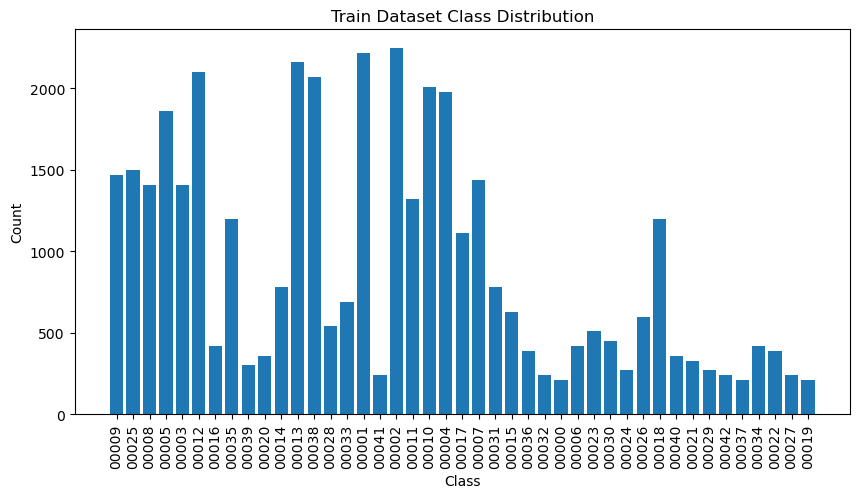

In [13]:
train_class_distribution = {}

for images, labels in train_ds:
    for label in labels.numpy():
        class_name = classes[label]
        if class_name in train_class_distribution:
            train_class_distribution[class_name] += 1
        else:
            train_class_distribution[class_name] = 1
#print(train_class_distribution) 
plot_distribution(train_class_distribution,'Train Dataset Class Distribution')

2023-06-12 23:00:32.822672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12630]
	 [[{{node Placeholder/_4}}]]
2023-06-12 23:00:32.823062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12630]
	 [[{{node Placeholder/_4}}]]


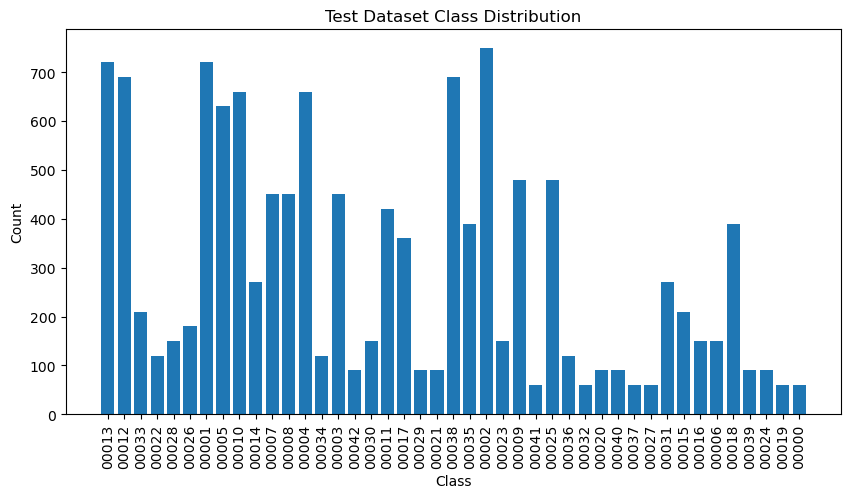

In [14]:
test_class_distribution = {}
for images, labels in test_ds:
    for label in labels.numpy():
        class_name = classes[label]
        if class_name in test_class_distribution:
            test_class_distribution[class_name] += 1
        else:
            test_class_distribution[class_name] = 1
#print(test_class_distribution)         
plot_distribution(test_class_distribution,'Test Dataset Class Distribution')

In [15]:
train_ds, validation_ds = create_validation_set(train_ds,0.2)

In [16]:
print('Number of batches train: ', train_ds.cardinality().numpy())
print('Number of batches validation: ',validation_ds.cardinality().numpy())
print('Number of batches test: ',test_ds.cardinality().numpy())

Number of batches train:  490
Number of batches validation:  123
Number of batches test:  198


In [17]:
# Normalize method
def normalize(images,labels):
    images = tf.cast(images,tf.float32)
    images /=255
    return images, labels

train_ds = train_ds.map(normalize,num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(normalize,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(normalize,num_parallel_calls=AUTOTUNE)


In [18]:
def one_hot_encode(image,label):
    label = tf.one_hot(label,depth=NUM_CLASSES)
    return image, label


train_enc_ds = train_ds.map(one_hot_encode,num_parallel_calls=AUTOTUNE)
validation_enc_ds = validation_ds.map(one_hot_encode,num_parallel_calls=AUTOTUNE)

In [19]:
train_enc_ds = train_enc_ds.cache().shuffle(buffer_size=10200)
train_enc_ds = train_enc_ds.cache().prefetch(buffer_size=AUTOTUNE)

validation_enc_ds = validation_enc_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
test_enc_ds = test_ds.map(one_hot_encode,num_parallel_calls=AUTOTUNE)
test_enc_ds = test_enc_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callback method
- Avoiding overfitting
- early stopping when validation accuracy no longer drops for a number of epochs
- record session to be available on tensorboard.

cd into log directory and <: tensorboard --logdir logs/path

In [21]:
def prepareCallbacks(path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper] #, tbCallBack

In [22]:
def model2(classCount, imgSize, channels):
    model = Sequential()
    model.add(Input(shape=(imgSize, imgSize, channels)))

    model.add(Conv2D(64, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(64, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

### Model and stats display

In [23]:
model2 = model2(43, 32, 3)
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0

In [25]:
file_pathM2, callbacksM2 = prepareCallbacks('bestM2')

historyV2 = model2.fit(train_enc_ds,
          epochs=40, 
          validation_data = validation_enc_ds, 
          callbacks=callbacksM2)

Epoch 1/40
170/490 [=========>....................] - ETA: 1:10 - loss: 0.0580 - accuracy: 0.9868

KeyboardInterrupt: 